In [92]:
import numpy as np
from matplotlib import pyplot as plt
from pathlib import Path
import matplotlib.gridspec as gridspec
from scipy.optimize import curve_fit
from scipy import optimize
import pickle as pkl
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [93]:
# initialisations

plt.rc('text', usetex=True)
plt.rc('font', size=14)

In [94]:
# QW and AQC data functions

def quantum_walk_data(n):
    probs = np.loadtxt(Path("./../Max2SAT_quantum/inf_time_probs/just_probs/inf_time_probs_n_" + str(n) + ".txt"))
    return probs


def adiabatic_data(n):
    if n <= 8:
        times = np.loadtxt(Path("./../Max2SAT_quantum/adiabatic/new_adiabatic_time_n_" + str(n) + ".txt"))
    else:
        times = np.genfromtxt(Path('./../Max2SAT_quantum/adiabatic/adiabatic_time_n_' + str(n) + '.csv'), delimiter=',', skip_header=1, dtype=str)[:, 1].astype(int)
    out = []
    num_discarded = 0
    for i, time in enumerate(times):
            if time >= 0:
                out.append(float(time))
            else:
                out.append(float('nan'))
                num_discarded += 1
    print("MY AQC DATA n:", n, " skipped:", num_discarded)
    return np.array(out)


# def adams_quantum_walk_data(n):
#     return np.genfromtxt('./../Max2SAT_quantum/qw_and_aqc_data/heug.csv', delimiter=',', skip_header=1+(n-5)*10000, usecols=2, max_rows=10000, dtype=str).astype(float)


# def adams_adiabatic_data(n):
#     '''returns time required to get 0.99 success probability'''
#     a = np.genfromtxt('./../Max2SAT_quantum/qw_and_aqc_data/heug.csv', delimiter=',',
#                       missing_values='', skip_header=1+(n-5)*10000, usecols=10, max_rows=10000, dtype=str)
#     b = []
#     skipped = 0
#     for i, element in enumerate(a):
#         if element != '':
#             b.append(float(element))
#         else:
#             b.append(float('nan'))
#             skipped += 1
#     print("ADAMS AQC DATA n:", n, " skipped:", skipped)
#     return np.array(b)

In [95]:
# other functions 

def get_all_formulae(n):
    '''returns all instances of a given n'''
    print(f'Getting all the formulae of size n={n}')
    instance_names = get_instance_names(n)
    instances = []
    for name in instance_names:
        instances.append(get_2sat_formula(name))
    return np.array(instances)


def get_hardest_formulae_qw(n, frac, return_indices=False):
    '''returns the hardest "frac" fraction of instances for QW at a given n'''
    print(
        f'Getting the hardest {frac} fraction of formulae of size n={n} for QW')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    hardest_indices = np.argsort(success_probs)[:num_instances]
    if return_indices:
        return hardest_indices
    hardest_instance_names = instance_names[hardest_indices]
    hardest_instances = []
    for name in hardest_instance_names:
        hardest_instances.append(get_2sat_formula(name))
    return np.array(hardest_instances)


def get_easiest_formulae_qw(n, frac, return_indices=False):
    '''returns the easiest "frac" fraction of instances for QW at a given n'''
    print(
        f'Getting the easiest {frac} fraction of formulae of size n={n} for QW')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    easiest_indices = np.argsort(success_probs)[(10000-num_instances):]
    if return_indices:
        return easiest_indices
    easiest_instance_names = instance_names[easiest_indices]
    easiest_instances = []
    for name in easiest_instance_names:
        easiest_instances.append(get_2sat_formula(name))
    return np.array(easiest_instances)


def get_hardest_boundary_formula_qw(n, frac, return_index=False):
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    instance = int(frac * 10000 - 1)
    boundary_index = np.argsort(success_probs)[instance]
    if return_index:
        return boundary_index
    boundary_instance_name = instance_names[boundary_index]
    return get_2sat_formula(boundary_instance_name)


def get_deciled_formulae_qw(n, return_indices=False):
    '''returns instances of a given n organised by QW decile'''
    print(f'Getting the formulae of size n={n} organised by QW decile')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(success_probs)
    deciled_instances = []
    for decile in range(10):
        print(f'Doing decile {decile+1}')
        deciled_instances.append([])
        end = int((10-decile) * (10000/10))
        start = int((9-decile) * (10000/10))
        indices = indices_by_hardness[start:end]
        if return_indices:
            deciled_instances[-1] = indices
        else:
            decile_instance_names = instance_names[indices]
            for name in decile_instance_names:
                deciled_instances[-1].append(get_2sat_formula(name))
    return np.array(deciled_instances)


def get_decile_boundary_formulae_qw(n, return_indices=False):
    '''returns the nine formulae on the boundaries of the QW deciles'''
    print(f'Getting the QW decile boundary formulae of size n={n}')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(success_probs)
    boundary_instances = []
    for decile in range(9):
        print(f'Doing decile {decile+1}')
        boundary = int((9-decile) * (10000/10))
        index = indices_by_hardness[boundary]
        if return_indices:
            boundary_instances.append(index)
        else:
            boundary_instances.append(get_2sat_formula(instance_names[index]))
    return boundary_instances


def get_hardest_formulae_aqc(n, frac, return_indices=False):
    '''returns the hardest "frac" fraction of instances for AQC at a given n'''
    print(
        f'Getting the hardest {frac} fraction of formulae of size n={n} for AQC')
    durations = adiabatic_data(n)
    durations = np.nan_to_num(durations, nan=np.max(durations)+1.0)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    hardest_indices = np.argsort(durations)[(10000-num_instances):]
    if return_indices:
        return hardest_indices
    hardest_instance_names = instance_names[hardest_indices]
    hardest_instances = []
    for name in hardest_instance_names:
        hardest_instances.append(get_2sat_formula(name))
    return np.array(hardest_instances)


def get_easiest_formulae_aqc(n, frac, return_indices=False):
    '''returns the easiest "frac" fraction of instances for AQC at a given n'''
    print(
        f'Getting the easiest {frac} fraction of formulae of size n={n} for AQC')
    durations = adiabatic_data(n)
    durations = np.nan_to_num(durations, nan=np.max(durations)+1.0)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    easiest_indices = np.argsort(durations)[:num_instances]
    if return_indices:
        return easiest_indices
    easiest_instance_names = instance_names[easiest_indices]
    easiest_instances = []
    for name in easiest_instance_names:
        easiest_instances.append(get_2sat_formula(name))
    return np.array(easiest_instances)


def get_hardest_boundary_formula_aqc(n, frac, return_index=False):
    durations = adiabatic_data(n)
    durations = np.nan_to_num(durations, nan=np.max(durations)+1.0)
    instance_names = get_instance_names(n)
    instance = int(frac * 10000 - 1)
    boundary_index = np.argsort(durations)[9999-instance]
    if return_index:
        return boundary_index
    boundary_instance_name = instance_names[boundary_index]
    return get_2sat_formula(boundary_instance_name)


def get_deciled_formulae_aqc(n, return_indices=False):
    '''returns instances of a given n organised by QW decile'''
    print(f'Getting the formulae of size n={n} organised by QW decile')
    durations = adiabatic_data(n)
    durations = np.nan_to_num(durations, nan=np.max(durations)+1.0)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(durations)
    deciled_instances = []
    for decile in range(10):
        print(f'Doing decile {decile+1}')
        deciled_instances.append([])
        start = int(decile * (10000/10))
        end = int((decile + 1) * (10000/10))
        indices = indices_by_hardness[start:end]
        if return_indices:
            deciled_instances[-1] = indices
        else:
            decile_instance_names = instance_names[indices]
            for name in decile_instance_names:
                deciled_instances[-1].append(get_2sat_formula(name))
    return np.array(deciled_instances)


def get_decile_boundary_formulae_aqc(n, return_indices=False):
    '''returns the nine formulae on the boundaries of the AQC deciles'''
    print(f'Getting the AQC decile boundary formulae of size n={n}')
    durations = adiabatic_data(n)
    durations = np.nan_to_num(durations, nan=np.max(durations)+1.0)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(durations)
    boundary_instances = []
    for decile in range(9):
        print(f'Doing decile {decile+1}')
        boundary = int((decile + 1) * (10000/10))
        index = indices_by_hardness[boundary]
        if return_indices:
            boundary_instances.append(index)
        else:
            boundary_instances.append(get_2sat_formula(instance_names[index]))
    return boundary_instances


def get_crosson_formulae():
    '''returns the instances that were data-mined to be hard for QA by Crosson'''
    instances = []
    for i in range(137):
        instance_name = str(i)
        instances.append(np.loadtxt(
            "./../../instances_crosson/" + instance_name + ".m2s").astype(int))
    return np.array(instances)


def get_instance_names(n):
    return np.genfromtxt('./../Max2SAT_quantum/qw_and_aqc_data/heug.csv', delimiter=',', skip_header=1, dtype=str)[(n-5)*10000:(n-4)*10000, 0].astype(str)


def get_instances():
    """returns array of instance names, array of corresponding n"""
    instance_data = np.genfromtxt(
        'm2s_nqubits.csv', delimiter=',', skip_header=1, dtype=str)    # path of csv file
    return instance_data[:, 0], instance_data[:, 1]


def get_2sat_formula(instance_name):
    # path of instance files in adam's format
    out = np.loadtxt("./../../instances_original/" + instance_name + ".m2s")
    return out.astype(int)


In [ ]:
# for n in range(5, 12):
#     adams = adams_quantum_walk_data(n)
#     mine = quantum_walk_data(n)

#     plt.figure()
#     plt.scatter(adams, mine)
#     plt.show()

In [ ]:
# for n in range(5, 14):
#     adams = adams_adiabatic_data(n)
#     mine = adiabatic_data(n)

#     plt.figure()
#     plt.scatter(adams, mine)
#     plt.show()

MY AQC DATA n: 5  skipped: 0
max: 51.0
n=5: m=-0.015005350641180693pm0.03617481857275738, c=5.1037168749040625pm0.0749819250075279, SR=0.06466138258480766
MY AQC DATA n: 11  skipped: 1
max: 77.0
n=11: m=-1.2732048459373253pm0.014782763187863552, c=0.12299723112123505pm0.071774085135358, SR=-0.5490026149698835


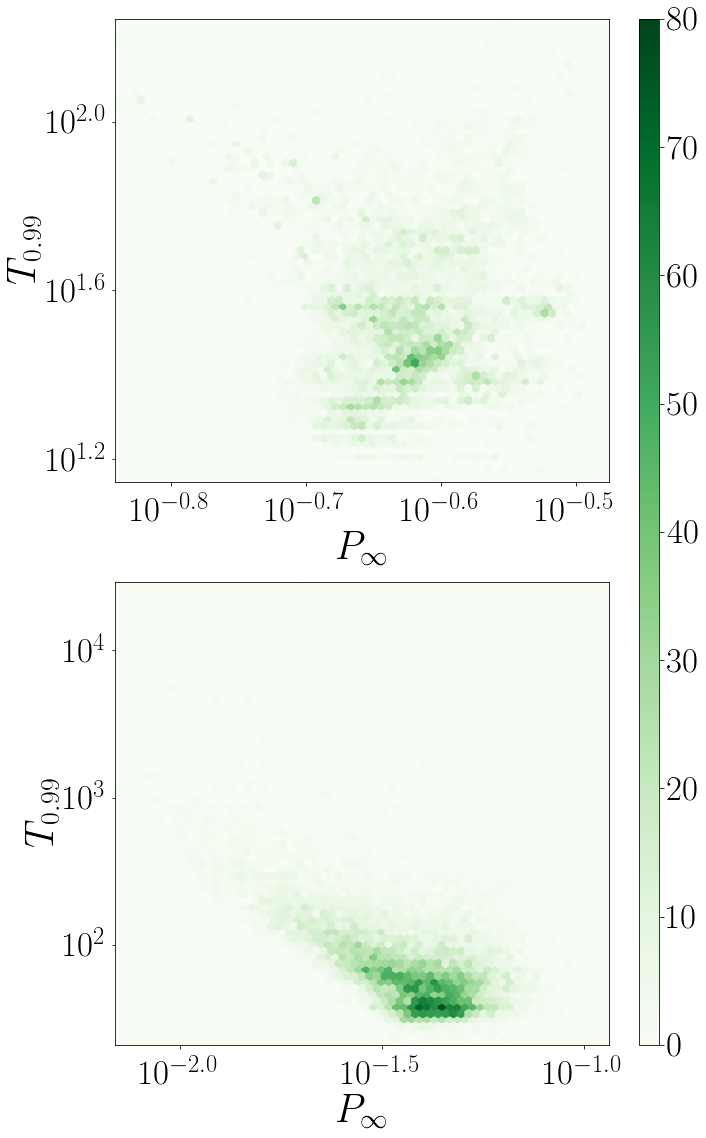

In [107]:
# plot AQC duration against QW success probability for n = 5, 11
# vertical

fig = plt.figure(figsize=(10, 16))
axs = []
gs1 = gridspec.GridSpec(2, 2, width_ratios=[1, 0.04])
# gs1.update(wspace=0.25)

# n = 5 plot
axs.append(plt.subplot(gs1[0, 0]))
n = 5

qw = quantum_walk_data(n)
aqc = adiabatic_data(n)

qw, aqc = qw[~np.isnan(aqc)], aqc[~np.isnan(aqc)]

vmax = 80

hex = plt.hexbin(np.log10(qw), np.log10(aqc), gridsize=65, vmin=0, vmax=vmax, cmap='Greens')
vals = hex.get_array()
print('max:', np.max(vals))
centres = hex.get_offsets()
x_min, x_max = np.min(centres[:, 0]), np.max(centres[:, 0])
y_min, y_max = np.min(centres[:, 1]), np.max(centres[:, 1])

plt.xlabel(r'$P_\infty$', fontsize=40)
plt.ylabel(r'$T_{0.99}$', fontsize=40)
xt = np.arange(-0.8, -0.4, 0.1)
xtl = ['$10^{' + f'{np.round(x,3)}' + '}$' for x in xt]
plt.xticks(xt, xtl, fontsize=35)
axs[0].tick_params(axis='x', which='major', pad=12)
yt = np.arange(1.2, 2.4, 0.4)
ytl = ['$10^{' + f'{np.round(y,3)}' + '}$' for y in yt]
plt.yticks(yt, ytl, fontsize=35)
# plt.tick_params(direction='in', size=5)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

xr_tmp, yr_tmp = np.argsort(np.log2(qw)), np.argsort(np.log2(aqc))
xr, yr = np.empty_like(xr_tmp), np.empty_like(yr_tmp)
xr[xr_tmp], yr[yr_tmp] = np.arange(len(qw)), np.arange(len(aqc))
covr = np.cov(xr, yr)
sr = covr[1, 0]/(np.std(xr)*np.std(yr))

line = lambda x, m, c: (x*m)+c
par, cov = curve_fit(line, np.log2(qw), np.log2(aqc))
m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
print(f'n={n}: m={m[0]}pm{m[1]}, c={c[0]}pm{c[1]}, SR={sr}')
fy = np.array([line(xval, m[0], c[0]) for xval in np.log2(qw)])

# n = 11 plot
axs.append(plt.subplot(gs1[1, 0]))
n = 11

qw = quantum_walk_data(n)
aqc = adiabatic_data(n)

qw, aqc = qw[~np.isnan(aqc)], aqc[~np.isnan(aqc)]

hex = plt.hexbin(np.log10(qw), np.log10(aqc), gridsize=65, vmin=0, vmax=vmax, cmap='Greens')
vals = hex.get_array()
print('max:', np.max(vals))
centres = hex.get_offsets()
x_min, x_max = np.min(centres[:, 0]), np.max(centres[:, 0])
y_min, y_max = np.min(centres[:, 1]), np.max(centres[:, 1])

plt.xlabel(r'$P_\infty$', fontsize=40)
plt.ylabel(r'$T_{0.99}$', fontsize=40)
xt = np.arange(-2.5, -0.5, 0.5)
xtl = ['$10^{' + f'{x}' + '}$' for x in xt]
plt.xticks(xt, xtl, fontsize=35)
axs[1].tick_params(axis='x', which='major', pad=12)
yt = np.arange(2, 5, 1)
ytl = ['$10^{' + f'{y}' + '}$' for y in yt]
plt.yticks(yt, ytl, fontsize=35)
# plt.tick_params(direction='in', size=5)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

ax = fig.add_subplot(gs1[:, 1])
# plt.axis('off')
cb = plt.colorbar(hex, cax=ax, use_gridspec=True)
cb.ax.tick_params(labelsize=35, size=5)
# pos = ax.get_position()
# points = pos.get_points()
# print(points)
# pos.set_points(points)
# ax.set_position(pos)

xr_tmp, yr_tmp = np.argsort(np.log2(qw)), np.argsort(np.log2(aqc))
xr, yr = np.empty_like(xr_tmp), np.empty_like(yr_tmp)
xr[xr_tmp], yr[yr_tmp] = np.arange(len(qw)), np.arange(len(aqc))
covr = np.cov(xr, yr)
sr = covr[1, 0]/(np.std(xr)*np.std(yr))

line = lambda x, m, c: (x*m)+c
par, cov = curve_fit(line, np.log2(qw), np.log2(aqc))
m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
print(f'n={n}: m={m[0]}pm{m[1]}, c={c[0]}pm{c[1]}, SR={sr}')
fy = np.array([line(xval, m[0], c[0]) for xval in np.log2(qw)])

plt.tight_layout()
# plt.savefig('aqcqw_hexbin_mydata.pdf', bbox_inches='tight')
plt.show()

In [58]:
# deciles initialisations

n_array_qw = np.arange(5, 12)
n_array_aqc = np.arange(5, 14)

line = lambda x, m, c: m*x + c

deciles = np.arange(10, dtype=int)
decile_boundaries = np.arange(9, dtype=int)

decile_colors_1 = np.zeros((10, 3))
for i in range(10):
    cn1, cn2 = 0.25 + ((i/10)*(0.75)), ((i/10)*(76/255)/1)
    decile_colors_1[9-i, :] = (0.0, cn1, cn2)

decile_colors_2 = np.zeros((10, 3))
for i in range(10):
    cn1, cn2 = 0.25 + ((i/10)*(0.75)), ((i/10)*(76/255)/1)
    decile_colors_2[9-i, :] = (cn1, cn2, 0.0)

In [74]:
# deciles functions

def get_all_formulae(n):
    '''returns all instances of a given n'''
    print(f'Getting all the formulae of size n={n}')
    instance_names = get_instance_names(n)
    instances = []
    for name in instance_names:
        instances.append(get_2sat_formula(name))
    return np.array(instances)


def get_hardest_formulae_qw(n, frac, return_indices=False):
    '''returns the hardest "frac" fraction of instances for QW at a given n'''
    print(
        f'Getting the hardest {frac} fraction of formulae of size n={n} for QW')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    hardest_indices = np.argsort(success_probs)[:num_instances]
    if return_indices:
        return hardest_indices
    hardest_instance_names = instance_names[hardest_indices]
    hardest_instances = []
    for name in hardest_instance_names:
        hardest_instances.append(get_2sat_formula(name))
    return np.array(hardest_instances)


def get_easiest_formulae_qw(n, frac, return_indices=False):
    '''returns the easiest "frac" fraction of instances for QW at a given n'''
    print(
        f'Getting the easiest {frac} fraction of formulae of size n={n} for QW')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    easiest_indices = np.argsort(success_probs)[(10000-num_instances):]
    if return_indices:
        return easiest_indices
    easiest_instance_names = instance_names[easiest_indices]
    easiest_instances = []
    for name in easiest_instance_names:
        easiest_instances.append(get_2sat_formula(name))
    return np.array(easiest_instances)


def get_hardest_boundary_formula_qw(n, frac, return_index=False):
    '''returns the instance where exactly "frac" fraction of instances are harder for QW'''
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    instance = int(frac * 10000)
    boundary_index = np.argsort(success_probs)[instance]
    if return_index:
        return boundary_index
    boundary_instance_name = instance_names[boundary_index]
    return get_2sat_formula(boundary_instance_name)


def get_deciled_formulae_qw(n, return_indices=False):
    '''returns instances of a given n organised by QW decile'''
    print(f'Getting the formulae of size n={n} organised by QW decile')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(success_probs)
    deciled_instances = []
    for decile in range(10):
        print(f'Doing decile {decile+1}')
        deciled_instances.append([])
        end = int((10-decile) * (10000/10))
        start = int((9-decile) * (10000/10))
        indices = indices_by_hardness[start:end]
        if return_indices:
            deciled_instances[-1] = indices
        else:
            decile_instance_names = instance_names[indices]
            for name in decile_instance_names:
                deciled_instances[-1].append(get_2sat_formula(name))
    return np.array(deciled_instances)


def get_decile_boundary_formulae_qw(n, return_indices=False):
    '''returns the nine formulae just below the boundaries of the QW deciles
       (i.e. the hardest formula of each decile, other than decile 10)'''
    print(f'Getting the QW decile boundary formulae of size n={n}')
    success_probs = quantum_walk_data(n)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(success_probs)
    boundary_instances = []
    for decile in range(9):
        print(f'Doing decile {decile+1}')
        boundary = int((9-decile) * (10000/10))
        index = indices_by_hardness[boundary]
        if return_indices:
            boundary_instances.append(index)
        else:
            boundary_instances.append(get_2sat_formula(instance_names[index]))
    return boundary_instances


def get_hardest_formulae_aqc(n, frac, return_indices=False):
    '''returns the hardest "frac" fraction of instances for AQC at a given n'''
    print(
        f'Getting the hardest {frac} fraction of formulae of size n={n} for AQC')
    durations = adiabatic_data(n)
    durations = nan_to_largest(durations, addition=1)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    hardest_indices = np.argsort(durations)[(10000-num_instances):]
    if return_indices:
        return hardest_indices
    hardest_instance_names = instance_names[hardest_indices]
    hardest_instances = []
    for name in hardest_instance_names:
        hardest_instances.append(get_2sat_formula(name))
    return np.array(hardest_instances)


def get_easiest_formulae_aqc(n, frac, return_indices=False):
    '''returns the easiest "frac" fraction of instances for AQC at a given n'''
    print(
        f'Getting the easiest {frac} fraction of formulae of size n={n} for AQC')
    durations = adiabatic_data(n)
    durations = nan_to_largest(durations, addition=1)
    instance_names = get_instance_names(n)
    num_instances = int(frac * 10000)
    easiest_indices = np.argsort(durations)[:num_instances]
    if return_indices:
        return easiest_indices
    easiest_instance_names = instance_names[easiest_indices]
    easiest_instances = []
    for name in easiest_instance_names:
        easiest_instances.append(get_2sat_formula(name))
    return np.array(easiest_instances)


def get_hardest_boundary_formula_aqc(n, frac, return_index=False):
    '''returns the instance where exactly "frac" fraction of instances are harder for AQC'''
    durations = adiabatic_data(n)
    durations = nan_to_largest(durations, addition=1)
    instance_names = get_instance_names(n)
    instance = int(frac * 10000)
    boundary_index = np.argsort(durations)[9999-instance]
    if return_index:
        return boundary_index
    boundary_instance_name = instance_names[boundary_index]
    return get_2sat_formula(boundary_instance_name)


def get_deciled_formulae_aqc(n, return_indices=False):
    '''returns instances of a given n organised by QW decile'''
    print(f'Getting the formulae of size n={n} organised by QW decile')
    durations = adiabatic_data(n)
    durations = nan_to_largest(durations, addition=1)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(durations)
    deciled_instances = []
    for decile in range(10):
        print(f'Doing decile {decile+1}')
        deciled_instances.append([])
        start = int(decile * (10000/10))
        end = int((decile + 1) * (10000/10))
        indices = indices_by_hardness[start:end]
        if return_indices:
            deciled_instances[-1] = indices
        else:
            decile_instance_names = instance_names[indices]
            for name in decile_instance_names:
                deciled_instances[-1].append(get_2sat_formula(name))
    return np.array(deciled_instances)


def get_decile_boundary_formulae_aqc(n, return_indices=False):
    '''returns the nine formulae just below the boundaries of the AQC deciles
       (i.e. the hardest formula of each decile, other than decile 10)'''
    print(f'Getting the AQC decile boundary formulae of size n={n}')
    durations = adiabatic_data(n)
    durations = nan_to_largest(durations, addition=1)
    instance_names = get_instance_names(n)
    indices_by_hardness = np.argsort(durations)
    boundary_instances = []
    for decile in range(9):
        print(f'Doing decile {decile+1}')
        boundary = int((decile + 1) * (10000/10) - 1)
        index = indices_by_hardness[boundary]
        if return_indices:
            boundary_instances.append(index)
        else:
            boundary_instances.append(get_2sat_formula(instance_names[index]))
    return boundary_instances


def get_instance_names(n):
    return np.genfromtxt('./../Max2SAT_quantum/qw_and_aqc_data/heug.csv', delimiter=',', skip_header=1, dtype=str)[(n-5)*10000:(n-4)*10000, 0].astype(str)


def get_instances():
    """returns array of instance names, array of corresponding n"""
    instance_data = np.genfromtxt(
        'm2s_nqubits.csv', delimiter=',', skip_header=1, dtype=str)    # path of csv file
    return instance_data[:, 0], instance_data[:, 1]


def get_2sat_formula(instance_name):
    # path of instance files in adam's format
    out = np.loadtxt("./../../instances_original/" + instance_name + ".m2s")
    return out.astype(int)


def get_instance_success_prob(n, instance):
    return float(np.genfromtxt(Path("./../Max2SAT_quantum/inf_time_probs/just_probs/inf_time_probs_n_" + str(n) + ".txt"), skip_header=instance, max_rows=1, dtype=str))


def get_instance_duration(n, instance):
    if n <= 8:
        val = float(np.genfromtxt(Path("./../Max2SAT_quantum/adiabatic/new_adiabatic_time_n_" + str(n) + ".txt"),
                        skip_header=instance, max_rows=1, dtype=str))
    else:
        val = float(np.genfromtxt(Path('./../Max2SAT_quantum/adiabatic/adiabatic_time_n_' + str(n) + '.csv'), delimiter=',',
                        skip_header=1+instance, max_rows=1, dtype=str)[1])
    if val >= 0:
        return float(val)
    return float('nan')


def nan_to_largest(x, addition=1):
    max = np.max(x[np.logical_not(np.isnan(x))])
    return np.nan_to_num(x, nan=max+addition)


def nan_to_pos_inf(x):
    return np.nan_to_num(x, nan=float('inf'))


def remove_nan(x):
    return x[np.logical_not(np.isnan(x))]


In [60]:
# get decile boundary indices for QW and AQC

# QW
qw_decile_boundary_indices = []    # list of list of indices
for n in n_array_qw:
    qw_decile_boundary_indices.append(
        get_decile_boundary_formulae_qw(n, return_indices=True))

# AQC
aqc_decile_boundary_indices = []   # list of list of indices
for n in n_array_aqc:
    aqc_decile_boundary_indices.append(
        get_decile_boundary_formulae_aqc(n, return_indices=True))

Getting the QW decile boundary formulae of size n=5
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Getting the QW decile boundary formulae of size n=6
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Getting the QW decile boundary formulae of size n=7
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Getting the QW decile boundary formulae of size n=8
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Getting the QW decile boundary formulae of size n=9
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Getting the QW decile boundary formulae of size n=10
Doing decile

In [61]:
# get hardest fraction boundary indices for QW and AQC

fraction = 0.01

qw_hardest_fraction_boundary_indices = []    # list of indices
for n in n_array_qw:
    qw_hardest_fraction_boundary_indices.append(
        get_hardest_boundary_formula_qw(n, fraction, return_index=True))

aqc_hardest_fraction_boundary_indices = []    # list of indices
for n in n_array_aqc:
    aqc_hardest_fraction_boundary_indices.append(
        get_hardest_boundary_formula_aqc(n, fraction, return_index=True))


MY AQC DATA n: 5  skipped: 0
MY AQC DATA n: 6  skipped: 0
MY AQC DATA n: 7  skipped: 0
MY AQC DATA n: 8  skipped: 0
MY AQC DATA n: 9  skipped: 1
MY AQC DATA n: 10  skipped: 2
MY AQC DATA n: 11  skipped: 1
MY AQC DATA n: 12  skipped: 6
MY AQC DATA n: 13  skipped: 28


In [81]:
# get decile boundary success probabilities and durations

success_probabilities_qw_decile_boundaries = np.zeros((9, len(n_array_qw)))
success_probabilities_aqc_decile_boundaries = np.zeros((9, len(n_array_aqc)))

durations_qw_decile_boundaries = np.zeros((9, len(n_array_aqc)))

for i, n in enumerate(n_array_qw):
    for decile in decile_boundaries:
        success_probabilities_qw_decile_boundaries[decile, i] = get_instance_success_prob(
            n, qw_decile_boundary_indices[i][decile])
        success_probabilities_aqc_decile_boundaries[decile, i] = get_instance_success_prob(
            n, aqc_decile_boundary_indices[i][decile])
        durations_qw_decile_boundaries[decile, i] = get_instance_duration(
            n, qw_decile_boundary_indices[i][decile])

durations_aqc_decile_boundaries = np.zeros((9, len(n_array_aqc)))

for i, n in enumerate(n_array_aqc):
    for decile in decile_boundaries:
        durations_aqc_decile_boundaries[decile, i] = get_instance_duration(
            n, aqc_decile_boundary_indices[i][decile])

In [82]:
# get hardest fraction boundary success probabilities and durations

success_probabilities_qw_hardest_fraction_boundary = np.zeros(len(n_array_qw))
success_probabilities_aqc_hardest_fraction_boundary = np.zeros(len(n_array_aqc))

durations_qw_hardest_fraction_boundary = np.zeros(len(n_array_aqc))

for i, n in enumerate(n_array_qw):
    success_probabilities_qw_hardest_fraction_boundary[i] = get_instance_success_prob(
        n, qw_hardest_fraction_boundary_indices[i])
    success_probabilities_aqc_hardest_fraction_boundary[i] = get_instance_success_prob(
        n, aqc_hardest_fraction_boundary_indices[i])
    durations_qw_hardest_fraction_boundary[i] = get_instance_duration(
        n, qw_hardest_fraction_boundary_indices[i])

durations_aqc_hardest_fraction_boundary = np.zeros(len(n_array_aqc))

for i, n in enumerate(n_array_aqc):
    durations_aqc_hardest_fraction_boundary[i] = get_instance_duration(
        n, aqc_hardest_fraction_boundary_indices[i])

In [83]:
# get decile indices for QW and AQC

# QW
qw_deciled_indices = []    # list of arrays of indices arrays
for n in n_array_qw:
    qw_deciled_indices.append(
        get_deciled_formulae_qw(n, return_indices=True))

qw_hardest_fraction_indices = []
for n in n_array_qw:
    qw_hardest_fraction_indices.append(
        get_hardest_formulae_qw(n, fraction, return_indices=True))

# AQC
aqc_deciled_indices = []   # list of arrays of indices arrays
for n in n_array_aqc:
    aqc_deciled_indices.append(
        get_deciled_formulae_aqc(n, return_indices=True))

aqc_hardest_fraction_indices = []
for n in n_array_aqc:
    aqc_hardest_fraction_indices.append(
        get_hardest_formulae_aqc(n, fraction, return_indices=True))

Getting the formulae of size n=5 organised by QW decile
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Doing decile 10
Getting the formulae of size n=6 organised by QW decile
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Doing decile 10
Getting the formulae of size n=7 organised by QW decile
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Doing decile 10
Getting the formulae of size n=8 organised by QW decile
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decile 8
Doing decile 9
Doing decile 10
Getting the formulae of size n=9 organised by QW decile
Doing decile 1
Doing decile 2
Doing decile 3
Doing decile 4
Doing decile 5
Doing decile 6
Doing decile 7
Doing decil

In [84]:
# get mean/median decile success probabilities and durations (and for hardest fractions)

mean_success_probabilities_qw_deciles = np.zeros((10, len(n_array_qw)))
median_success_probabilities_qw_deciles = np.zeros((10, len(n_array_qw)))
mean_success_probabilities_qw_hardest_fraction = np.zeros(len(n_array_qw))
median_success_probabilities_qw_hardest_fraction = np.zeros(len(n_array_qw))
mean_success_probabilities_aqc_deciles = np.zeros((10, len(n_array_aqc)))
median_success_probabilities_aqc_deciles = np.zeros((10, len(n_array_aqc)))
mean_success_probabilities_aqc_hardest_fraction = np.zeros(len(n_array_aqc))
median_success_probabilities_aqc_hardest_fraction = np.zeros(len(n_array_aqc))

mean_durations_qw_deciles = np.zeros((10, len(n_array_aqc)))
median_durations_qw_deciles = np.zeros((10, len(n_array_aqc)))
mean_durations_qw_hardest_fraction = np.zeros(len(n_array_aqc))
median_durations_qw_hardest_fraction = np.zeros(len(n_array_aqc))

success_probabilities_aqc_hardest_fraction = np.zeros((len(n_array_aqc), int(fraction*10000)))
durations_qw_hardest_fraction = np.zeros((len(n_array_aqc), int(fraction*10000)))

for i, n in enumerate(n_array_qw):
    success_probs = quantum_walk_data(n)
    durations = adiabatic_data(n)
    for decile in deciles:
        qw_decile_success_probs = success_probs[qw_deciled_indices[i][decile]]
        mean_success_probabilities_qw_deciles[decile, i] = np.mean(
            qw_decile_success_probs)
        median_success_probabilities_qw_deciles[decile, i] = np.median(
            qw_decile_success_probs)
        
        aqc_decile_success_probs = success_probs[aqc_deciled_indices[i][decile]]
        mean_success_probabilities_aqc_deciles[decile, i] = np.mean(
            aqc_decile_success_probs)
        median_success_probabilities_aqc_deciles[decile, i] = np.median(
            aqc_decile_success_probs)
        
        qw_decile_durations = durations[qw_deciled_indices[i][decile]]
        mean_durations_qw_deciles[decile, i] = np.mean(remove_nan(qw_decile_durations))
        median_durations_qw_deciles[decile, i] = np.median(nan_to_pos_inf(qw_decile_durations))
        if median_durations_qw_deciles[decile, i] == float('inf'):
            median_durations_qw_deciles[decile, i] = float('nan')

    qw_hardest_success_probs = success_probs[qw_hardest_fraction_indices[i]]
    mean_success_probabilities_qw_hardest_fraction[i] = np.mean(
        qw_hardest_success_probs)
    median_success_probabilities_qw_hardest_fraction[i] = np.median(
        qw_hardest_success_probs)
    
    aqc_hardest_success_probs = success_probs[aqc_hardest_fraction_indices[i]]
    mean_success_probabilities_aqc_hardest_fraction[i] = np.mean(aqc_hardest_success_probs)
    median_success_probabilities_aqc_hardest_fraction[i] = np.median(aqc_hardest_success_probs)
    success_probabilities_aqc_hardest_fraction[i, :] = aqc_hardest_success_probs

    qw_hardest_durations = durations[qw_hardest_fraction_indices[i]]
    mean_durations_qw_hardest_fraction[i] = np.mean(remove_nan(qw_hardest_durations))
    median_durations_qw_hardest_fraction[i] = np.median(nan_to_pos_inf(qw_hardest_durations))
    if median_durations_qw_hardest_fraction[i] == float('inf'):
        median_durations_qw_hardest_fraction[i] = float('nan')
    durations_qw_hardest_fraction[i, :] = nan_to_pos_inf(qw_hardest_durations)

mean_durations_aqc_deciles = np.zeros((10, len(n_array_aqc)))
median_durations_aqc_deciles = np.zeros((10, len(n_array_aqc)))
mean_durations_aqc_hardest_fraction = np.zeros(len(n_array_aqc))
median_durations_aqc_hardest_fraction = np.zeros(len(n_array_aqc))

for i, n in enumerate(n_array_aqc):
    durations = adiabatic_data(n)
    for decile in deciles:
        aqc_decile_durations = durations[aqc_deciled_indices[i][decile]]
        mean_durations_aqc_deciles[decile, i] = np.mean(remove_nan(aqc_decile_durations))
        median_durations_aqc_deciles[decile, i] = np.median(nan_to_pos_inf(aqc_decile_durations))
        if median_durations_aqc_deciles[decile, i] == float('inf'):
            median_durations_aqc_deciles[decile, i] = float('nan')
    
    aqc_hardest_durations = durations[aqc_hardest_fraction_indices[i]]
    mean_durations_aqc_hardest_fraction[i] = np.mean(remove_nan(aqc_hardest_durations))
    median_durations_aqc_hardest_fraction[i] = np.median(nan_to_pos_inf(aqc_hardest_durations))
    if median_durations_aqc_hardest_fraction[i] == float('inf'):
        median_durations_aqc_hardest_fraction[i] = float('nan')

MY AQC DATA n: 5  skipped: 0
MY AQC DATA n: 6  skipped: 0
MY AQC DATA n: 7  skipped: 0
MY AQC DATA n: 8  skipped: 0
MY AQC DATA n: 9  skipped: 1
MY AQC DATA n: 10  skipped: 2
MY AQC DATA n: 11  skipped: 1
MY AQC DATA n: 5  skipped: 0
MY AQC DATA n: 6  skipped: 0
MY AQC DATA n: 7  skipped: 0
MY AQC DATA n: 8  skipped: 0
MY AQC DATA n: 9  skipped: 1
MY AQC DATA n: 10  skipped: 2
MY AQC DATA n: 11  skipped: 1
MY AQC DATA n: 12  skipped: 6
MY AQC DATA n: 13  skipped: 28


Scaling exponents for QW deciles:
-0.3939851658911968 +- 0.0015648751284991955
-0.40769437960995814 +- 0.0010884098969746983
-0.41845480831960846 +- 0.0009228730502617192
-0.4304522356476099 +- 0.001528725937552148
-0.4432252554626961 +- 0.0014581780617673804
-0.45911583479839607 +- 0.0018481501933968235
-0.47852704050747774 +- 0.0027299037441333904
-0.5068363601964598 +- 0.003457637142719969
-0.5559667244837223 +- 0.003971883111026398
Scaling exponent for the 99th QW percentile: -0.6641482306863852 +- 0.011474638177059716

Scaling exponents for AQC deciles:
0.11006287465335352 +- 0.007864484245765472
0.12120435402556284 +- 0.0059097479868620816
0.13229424588770206 +- 0.0032157845908397198
0.14423566522362916 +- 0.004164202302918841
0.15785404924579935 +- 0.005088699535717439
0.17453047992052761 +- 0.00619038712634382
0.19240329431874675 +- 0.005831230056105904
0.2182329782625314 +- 0.003093071832503141
0.2774586435043044 +- 0.0056937121444425014
Scaling exponent for the 99th AQC perce

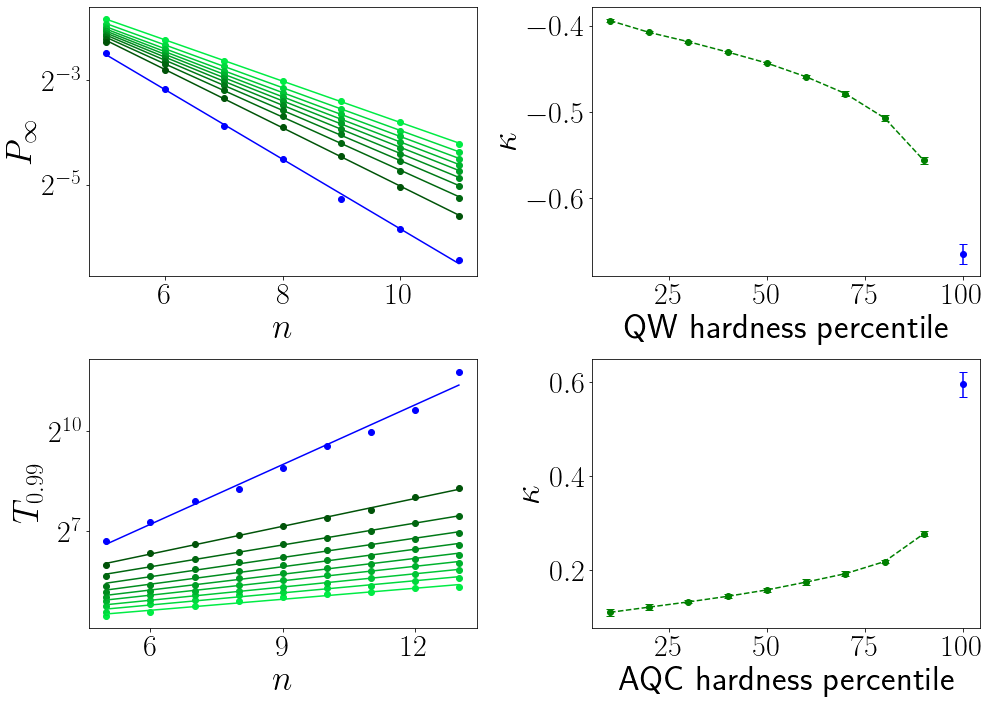

In [91]:
# percentile plots for QW/AQC using corresponding hardness

fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# log-linear plot of QW probabilities/QW deciles using boundary values

scalings = np.zeros_like(decile_boundaries, dtype=np.float64)
scalings_error = np.zeros_like(decile_boundaries, dtype=np.float64)
for decile in decile_boundaries:
    y = np.log2(success_probabilities_qw_decile_boundaries[decile, :])
    par, cov = optimize.curve_fit(line, n_array_qw, y)
    m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
    fit = 2**np.array([line(x, m[0], c[0]) for x in n_array_qw])
    scalings[decile] = m[0]
    scalings_error[decile] = m[1]

    axs[0, 0].scatter(
        n_array_qw, success_probabilities_qw_decile_boundaries[decile, :], color=decile_colors_1[decile])
    axs[0, 0].plot(n_array_qw, fit, color=decile_colors_1[decile])

y = np.log2(success_probabilities_qw_hardest_fraction_boundary)
par, cov = optimize.curve_fit(line, n_array_qw, y)
m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
scaling_hardest = m[0]
scaling_hardest_error = m[1]
fit = 2**np.array([line(x, m[0], c[0]) for x in n_array_qw])
axs[0, 0].scatter(
    n_array_qw, success_probabilities_qw_hardest_fraction_boundary, color='blue')
axs[0, 0].plot(n_array_qw, fit, color='blue')
axs[0, 0].set_yscale('log', base=2)
axs[0, 0].set_ylabel('$P_\infty$', fontsize=35)
axs[0, 0].set_xlabel('$n$', fontsize=35)
axs[0, 0].tick_params(axis='both', labelsize=30)

axs[0, 1].scatter(10 * (decile_boundaries+1), scalings, color='green')
axs[0, 1].errorbar(10*(decile_boundaries+1), scalings, yerr=scalings_error, capsize=4.0, fmt='none', ecolor='green')
axs[0, 1].scatter(10 * 9.99, scaling_hardest, color='blue')
axs[0, 1].errorbar(10*9.99, scaling_hardest, yerr=scaling_hardest_error, capsize=4.0, fmt='none', ecolor='blue')
axs[0, 1].plot(10 * (decile_boundaries+1), scalings,
               color='green', linestyle='--')
axs[0, 1].set_ylabel(r'$\kappa$', fontsize=35)
axs[0, 1].set_xlabel('QW hardness percentile', fontsize=35)
axs[0, 1].tick_params(axis='both', labelsize=30)

print('Scaling exponents for QW deciles:')
for i in range(len(deciles)-1):
    print(f'{scalings[i]} +- {scalings_error[i]}')
print(f'Scaling exponent for the 99th QW percentile: {scaling_hardest} +- {scaling_hardest_error}')

# log-linear plot of AQC durations/AQC deciles using boundary values

scalings = np.zeros_like(decile_boundaries, dtype=np.float64)
scalings_error = np.zeros_like(decile_boundaries, dtype=np.float64)
for decile in decile_boundaries:
    y = np.log2(durations_aqc_decile_boundaries[decile, :])
    par, cov = optimize.curve_fit(line, n_array_aqc, y)
    m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
    fit = 2**np.array([line(x, m[0], c[0]) for x in n_array_aqc])
    scalings[decile] = m[0]
    scalings_error[decile] = m[1]

    axs[1, 0].scatter(n_array_aqc,
                      durations_aqc_decile_boundaries[decile, :], color=decile_colors_1[decile])
    axs[1, 0].plot(n_array_aqc, fit, color=decile_colors_1[decile])

y = np.log2(durations_aqc_hardest_fraction_boundary)
y = y[~np.isnan(y)]
par, cov = optimize.curve_fit(line, n_array_aqc[:len(y)], y)
m, c = (par[0], np.sqrt(cov[0, 0])), (par[1], np.sqrt(cov[1, 1]))
scaling_hardest = m[0]
scaling_hardest_error = m[1]
fit = 2**np.array([line(x, m[0], c[0]) for x in n_array_aqc])
axs[1, 0].scatter(n_array_aqc,
                  durations_aqc_hardest_fraction_boundary, color='blue')
axs[1, 0].plot(n_array_aqc, fit, color='blue')
axs[1, 0].set_yscale('log', base=2)
axs[1, 0].set_ylabel('$T_{0.99}$', fontsize=35)
axs[1, 0].set_xlabel('$n$', fontsize=35)
axs[1, 0].set_xticks([6, 9, 12])
axs[1, 0].tick_params(axis='both', labelsize=30)

axs[1, 1].errorbar(10*(decile_boundaries+1), scalings, yerr=scalings_error, capsize=4.0, fmt='none', ecolor='green')
axs[1, 1].scatter(10*(decile_boundaries+1), scalings, color='green')
axs[1, 1].errorbar(10*9.99, scaling_hardest, yerr=scaling_hardest_error, capsize=4.0, fmt='none', ecolor='blue')
axs[1, 1].scatter(10*9.99, scaling_hardest, color='blue')
axs[1, 1].plot(10*(decile_boundaries+1), scalings,
               color='green', linestyle='--')
axs[1, 1].set_ylabel(r'$\kappa$', fontsize=35)
axs[1, 1].set_xlabel('AQC hardness percentile', fontsize=35)
axs[1, 1].tick_params(axis='both', labelsize=30)

print('\nScaling exponents for AQC deciles:')
for i in range(len(deciles)-1):
    print(f'{scalings[i]} +- {scalings_error[i]}')
print(f'Scaling exponent for the 99th AQC percentile: {scaling_hardest} +- {scaling_hardest_error}')

fig.tight_layout()
# plt.savefig('qw_aqc_decile_boundaries_mydata.pdf', dpi=200)
plt.show()

In [96]:
# initialisations for sat/unsatisfiable histograms

plt.rc('text', usetex=True)
plt.rc('font', size=13)

def zero_to_nan(array):
    """Replace every 0 with 'nan' and return a copy."""
    return [float('nan') if x==0 else x for x in array]


def get_satisfiable_list(n):
    data = np.genfromtxt('./../Max2SAT/m2s_satisfiable.csv', delimiter=',', skip_header=1, dtype=str)
    satisfiable_data = data[:, 1]
    m = n - 5
    return satisfiable_data[m*10000:(m+1)*10000]

MY AQC DATA n: 5  skipped: 0
MY AQC DATA n: 11  skipped: 1


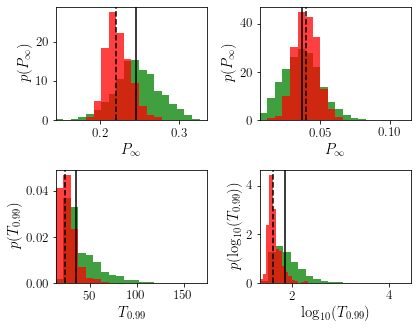

In [106]:
fig = plt.figure(figsize=(6, 4.75))

gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])
# gs.update(hspace=0.45, wspace=0.4)
axs = list()
axs.append(fig.add_subplot(gs[0]))
axs.append(fig.add_subplot(gs[1]))
axs.append(fig.add_subplot(gs[2]))
axs.append(fig.add_subplot(gs[3]))

n_list = [5, 11]
num_bins = 20

for i, n in enumerate(n_list):
        qw_probs_list = []
        aqc_times_list = []

        qw_probs = quantum_walk_data(n)
        aqc_times = adiabatic_data(n)
        satisfiable_list = get_satisfiable_list(n).astype(int)

        probs_satisfiable = np.delete(qw_probs, np.where(satisfiable_list == 0))
        probs_unsatisfiable = np.delete(qw_probs, np.where(satisfiable_list == 1))

        times_satisfiable = np.delete(aqc_times, np.where(satisfiable_list == 0))
        times_unsatisfiable = np.delete(aqc_times, np.where(satisfiable_list == 1))

        # delete NaN values for AQC
        times_satisfiable = np.delete(times_satisfiable, np.where(np.isnan(times_satisfiable)))
        times_unsatisfiable = np.delete(times_unsatisfiable, np.where(np.isnan(times_unsatisfiable)))

        min_prob = np.min((np.min(probs_satisfiable), np.min(probs_unsatisfiable)))
        max_prob = np.max((np.max(probs_satisfiable), np.max(probs_unsatisfiable)))

        min_time = np.min((np.min(times_satisfiable), np.min(times_unsatisfiable)))
        max_time = np.max((np.max(times_satisfiable), np.max(times_unsatisfiable)))


        x_qw = np.linspace(min_prob-0.00001, max_prob+0.00001, num=num_bins+1)
        x_aqc = np.linspace(min_time-0.1, max_time+0.1, num=num_bins+1)

        x_aqc_log = np.ones(num_bins+1) * min_time
        multiply_factor = 2**((np.log2(max_time)-np.log2(min_time))/num_bins)
        x_aqc_log = [x_aqc_log[i] * multiply_factor**i for i in range(len(x_aqc_log))]
        x_aqc_log[-1] += 1

        sat_average_qw = np.median(probs_satisfiable)
        unsat_average_qw = np.median(probs_unsatisfiable)

        sat_average_aqc = np.median(times_satisfiable)
        unsat_average_aqc = np.median(times_unsatisfiable)

        axs[i].hist(probs_unsatisfiable, x_qw, color='green', alpha=0.75, density=True, label='unsatisfiable')
        axs[i].hist(probs_satisfiable, x_qw, color='red', alpha=0.75, density=True, label='satisfiable')
        ylim = axs[i].get_ylim()
        axs[i].vlines(sat_average_qw, 0, ylim[1], color='black', linestyle='--')
        axs[i].vlines(unsat_average_qw, 0, ylim[1], color='black')
        axs[i].set_ylim(ylim)
        axs[i].set_xlabel(r"$P_\infty$", fontsize=15)
        axs[i].set_ylabel(r"$p(P_\infty)$", fontsize=15)
        axs[i].set_xlim((min_prob, max_prob))
        axs[i].tick_params(axis='both', labelsize=13)

        if i == 0:
                axs[i+2].hist(times_unsatisfiable, x_aqc, color='green', alpha=0.75, density=True, label='unsatisfiable')
                axs[i+2].hist(times_satisfiable, x_aqc, color='red', alpha=0.75, density=True, label='satisfiable')
                ylim = axs[i+2].get_ylim()
                axs[i+2].vlines(sat_average_aqc, 0, ylim[1], color='black', linestyle='--')
                axs[i+2].vlines(unsat_average_aqc, 0, ylim[1], color='black')
                axs[i+2].set_ylim(ylim)
                axs[i+2].set_xlabel(r'$T_{0.99}$', fontsize=15)
                axs[i+2].set_ylabel(r'$p(T_{0.99})$', fontsize=15)
                axs[i+2].set_xlim((min_time, max_time))
                axs[i+2].tick_params(axis='both', labelsize=13)
        else:
                # ############################ LOGARITHMIC PLOTS ###############################
                h, b = np.histogram(np.log10(times_unsatisfiable), bins=num_bins, density=True)
                db = b[1:]-b[:-1]
                b = (b[1:]+b[:-1])/2
                htot = np.dot(h, db)
                h = (h/htot)
                axs[i+2].bar(b, h, width=db*1.0, alpha=0.75,
                        color='green', label='unsatisfaiable')
                h, b = np.histogram(np.log10(times_satisfiable), bins=num_bins, density=True)
                db = b[1:]-b[:-1]
                b = (b[1:]+b[:-1])/2
                htot = np.dot(h, db)
                h = (h/htot)
                axs[i+2].bar(b, h, width=db*1.0, alpha=0.75,
                        color='red', label='satisfiable')
                ylim = axs[i+2].get_ylim()
                axs[i+2].vlines(np.log10(sat_average_aqc), 0, ylim[1], color='black', linestyle='--')
                axs[i+2].vlines(np.log10(unsat_average_aqc), 0, ylim[1], color='black')
                axs[i+2].set_ylim(ylim)
                # axs[i+2].set_xscale('log')
                axs[i+2].set_xlabel(r'$\log_{10}(T_{0.99})$', fontsize=15)
                axs[i+2].set_ylabel(r'$p(\log_{10}(T_{0.99}))$', fontsize=15)
                axs[i+2].set_xlim((np.log10(min_time), np.log10(max_time)))
                axs[i+2].tick_params(axis='both', labelsize=13)

fig.tight_layout()
plt.savefig('hardness_histograms_satisfiable_vs_unsatisfiable_mydata.pdf', dpi=200)
plt.show()


In [ ]:
# initialisations for sat/unsatisfiable scalings
